In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.float_format',lambda x:'%.3f' % x)

import pdfkit as pdf
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import seaborn as sns
sns.set_palette('muted')
sns.set_style('darkgrid')
import os, sys
import warnings
warnings.filterwarnings('ignore')

## freeze window to checkup the data

In [2]:
# from ipywidgets import interact, IntSlider
# from IPython.display import display
# # freeze window to checkup the data
# def freeze_header(df, num_rows=1000, num_columns=10, step_rows=1000,
#                   step_columns=1):
#     """
#     Freeze the headers (column and index names) of a Pandas DataFrame. A widget
#     enables to slide through the rows and columns.

#     Parameters
#     ----------
#     df : Pandas DataFrame
#         DataFrame to display
#     num_rows : int, optional
#         Number of rows to display
#     num_columns : int, optional
#         Number of columns to display
#     step_rows : int, optional
#         Step in the rows
#     step_columns : int, optional
#         Step in the columns
        
#     Returns
#     -------
#     Displays the DataFrame with the widget
#     """
#     @interact(last_row=IntSlider(min=min(num_rows, df.shape[0]),
#                                  max=df.shape[0],
#                                  step=step_rows,
#                                  description='rows',
#                                  readout=False,
#                                  disabled=False,
#                                  continuous_update=True,
#                                  orientation='horizontal',
#                                  slider_color='purple'),
#               last_column=IntSlider(min=min(num_columns, df.shape[1]),
#                                     max=df.shape[1],
#                                     step=step_columns,
#                                     description='columns',
#                                     readout=False,
#                                     disabled=False,
#                                     continuous_update=True,
#                                     orientation='horizontal',
#                                     slider_color='purple'))
#     def _freeze_header(last_row, last_column):
#         display(df.iloc[max(0, last_row-num_rows):last_row,
#                         max(0, last_column-num_columns):last_column])

# 1.Original Data import

In [28]:
### merge the training and testing set
data_path = os.path.join(os.getcwd(),'data')
# T1 = pd.read_excel(os.path.join(data_path, "LendingClubData_training.xlsx"))
# T2 = pd.read_excel(os.path.join(data_path, "LendingClubData_testing.xlsx"))
# data = pd.concat([T1,T2])
# data = data.reset_index().drop(columns=["index"])
# data.to_csv(os.path.join(data_path,"LendingClubData_original.csv"),index = False)
data = pd.read_csv(os.path.join(data_path, "LendingClubData_original.csv"))
df_description = pd.read_excel(os.path.join(data_path, 'LendingClubDataDictionary.xlsx'),sheet_name = "LoanStats").dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


# 2.data preprocessing
## 2.1 Missing values - feature level

In [4]:
# data preprocessing
print("Original data: LendingClubData_original.csv")
print(f"Shape of DataFrame: {data.shape}")

Original data: LendingClubData_original.csv
Shape of DataFrame: (39786, 145)


In [76]:
# calculate missing rate of variables
def cal_missing(df):
    missing = df.isnull().sum()/df.shape[0]
    missing = pd.DataFrame(missing).reset_index()
    missing = missing.rename(columns={'index':'col',0 :'missing_pct'})
    # sort the features by missing ratio
    missing = missing.sort_values('missing_pct',ascending = False).reset_index(drop=True)
    return missing

# distribution of missing rate
def plot_missing_distribution(df, plt_size = (8,6)):
    missing = cal_missing(df)
    plt.figure(figsize = plt_size)
    plt.rcParams["font.sans-serif"] = ['Microsoft YaHei']
    plt.rcParams['axes.unicode_minus'] = False
    x = missing['missing_pct']
    plt.hist(x=x,bins=np.arange(0,1.1,0.1),color='red',ec='k',alpha=0.9)
    plt.ylabel('Number of missing variables')
    plt.xlabel('Missing rate')
    return plt.show()

# delete variables whose portion of missing value are greater than the threshold
def delete_missing_variable(df,threshold = 1):
    df2 = df.copy()
    missing = cal_missing(df)
    missing_col = (missing[missing["missing_pct"] >= threshold])['col']
    df2 = df2.drop(missing_col, axis=1)
    return df2

# delete constant variable
def delete_const_variable(df, threshold = 1):
    df2 = df.copy()
    const_col = []
    for col in df.columns:
        pct = df[col].value_counts().iloc[0]/df[col].notnull().sum()
        if pct >= threshold:
            const_col.append(col)
    df2 = df2.drop(const_col,axis=1)
    return df2


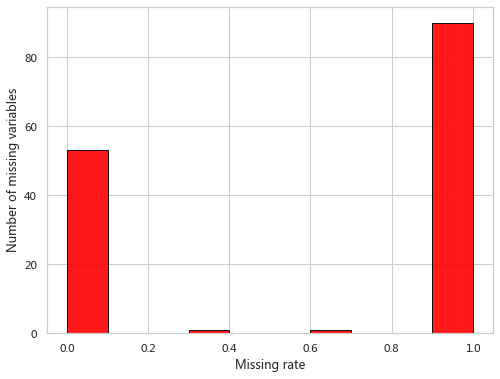

Original number of features: 145
Number of features after delete variables have missing more than 0.4: 54
Number of features after delete constant variables where one value takes more than 0.95 : 39


In [77]:
plot_missing_distribution(data)
print("Original number of features: \033[1m{}\033[0m".format(data.shape[1]))
missing_threshold = 0.4
df = delete_missing_variable(data,threshold = missing_threshold)
print("Number of features after delete variables have missing more than \033[1m{}\033[0m: \033[1m{}\033[0m".format(missing_threshold, df.shape[1]))
constant_threshold = 0.95
df = delete_const_variable(df,threshold = constant_threshold)
print("Number of features after delete constant variables where one value takes more than \033[1m{}\033[0m : \033[1m{}\033[0m".format(constant_threshold, df.shape[1]))

## 2.2 Missing values - record level

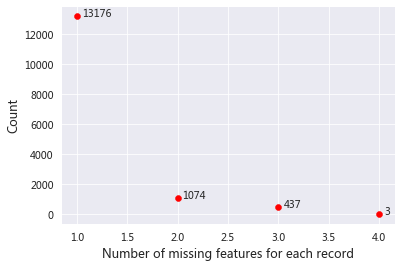

Shape of DataFrame: (39786, 39)


In [7]:
# delete records which have missing observations
record_missing_status = df.isnull().sum(axis=1)
missing_feature_amount = np.arange(1,5)
count_of_missing_record = [sum(record_missing_status == k) for k in missing_feature_amount ]

# plot 
plt.figure()
plt.scatter(missing_feature_amount,count_of_missing_record,color = "red")
plt.ylabel('Count')
plt.xlabel('Number of missing features for each record')
for i in range(len(missing_feature_amount)):
    plt.text(missing_feature_amount[i]+0.05,
             count_of_missing_record[i],
             count_of_missing_record[i],
             #bbox=dict(facecolor='red', alpha=0.5)
            )
    
plt.show()
###
print(f"Shape of DataFrame: {df.shape}")

## 2.3 Fill missing value & Feature Transformation

In [8]:
def value_count(df,colname):
    return df[colname].value_counts()
def plot_count_distribution(df, colname, figsize = (8,6),fontsize = 15,position = 5,percentage = False):
    fig, ax= plt.subplots(figsize = figsize)
    sns.set_style('whitegrid')
    sns.set_context('notebook')
    ax = sns.countplot(x=colname,data = df)
    # add acnnotation
    if not percentage:        
        for p in ax.patches:
            value = p.get_height()
            height, width =p.get_height(), p.get_width()
            x=p.get_x()+width * (position/10)
            y=p.get_y()+height+0.08
            ax.annotate(value,(x,y),fontsize = fontsize)
    else:
        total = len(df[colname])
        for p in ax.patches:
            value = '{:.2f}%'.format(100 * p.get_height()/total)
            height, width =p.get_height(), p.get_width()
            x=p.get_x()+width * (position/10)
            y=p.get_y()+height+0.08
            ax.annotate(value,(x,y),fontsize = fontsize)
    

    plt.title(f"Countplot -- {colname}",size=20)
    plt.ylabel("count",size = 15)
    plt.xlabel(colname,size = 15)
    plt.xticks(fontsize =13)
    plt.yticks(rotation =50,fontsize =13)
    plt.show()
    plt.close(fig)
    return plt.show()

In [9]:
numerical = []
categorical = []
for i in df.columns:
    if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
        numerical.append(i)
    else:
        categorical.append(i)
print("Numerical: {}\n".format(numerical))
print("Categorical: {}".format(categorical))
# selected_feature

features = {
    "term": 1 ,# numerical,
    "emp_length": 2 ,# label encoding,
    "home_ownership": 2, # label encoding
    "verification_status": 2, # label encoding,
}


Numerical: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt']

Categorical: ['term', 'grade', 'sub_grade', 'emp_title', 'emp_length', 'home_ownership', 'verification_status', 'issue_d', 'loan_status', 'desc', 'purpose', 'title', 'zip_code', 'addr_state', 'earliest_cr_line', 'last_pymnt_d', 'last_credit_pull_d']


In [10]:
# columns which contain missing value
df.isnull().sum()[df.isnull().any()]

emp_title              2467
emp_length             1078
desc                  12967
title                    12
revol_util               50
last_pymnt_d             71
last_credit_pull_d        2
dtype: int64

In [11]:
df_new = pd.DataFrame()
# response
# df_new["loan_status"] = df["loan_status"] #.map({"Fully Paid":0, "Charged Off":1})
df_new["loan_status"] = df["loan_status"].map({"Fully Paid":"Fully Paid", "Charged Off":"charged Off"})
# term : The number of payments on the loan. Values are in months and can be either 36 or 60.
df_new["term"] = df["term"].map({" 36 months":36, " 60 months":60})

# home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
df_new["home_ownership"] = df["home_ownership"].map({"NONE":1,"OTHER":1,"RENT":2,"MORTGAGE":3,"OWN":4})

# emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
df["emp_length"].fillna(0,inplace=True)
df_new["emp_length"]= np.where(df["emp_length"]== "10+ years", 10,
                           np.where(df["emp_length"] == "1 year", 1,
                                   np.where(df["emp_length"] == "2 years", 2,
                                           np.where(df["emp_length"] == "3 years", 3,
                                                   np.where(df["emp_length"] == "4 years", 4,
                                                           np.where(df["emp_length"] == "5 years", 5,
                                                                   np.where(df["emp_length"] == "6 years", 6,
                                                                            np.where(df["emp_length"] == "7 years", 7,
                                                                                     np.where(df["emp_length"] == "8 years", 8,
                                                                                              np.where(df["emp_length"] == "9 years", 9, 0))))))))))
# verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
df_new["verification_status"] = df["verification_status"].map({"Not Verified":1,"Verified":2,"Source Verified":3})


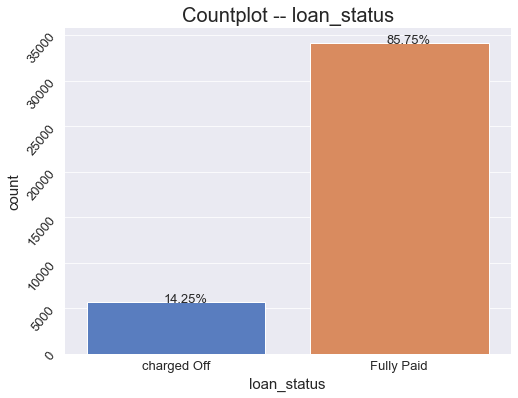

In [12]:
# unbalanced data
plot_count_distribution(df_new, "loan_status",fontsize = 13,position = 4.3,percentage = True)

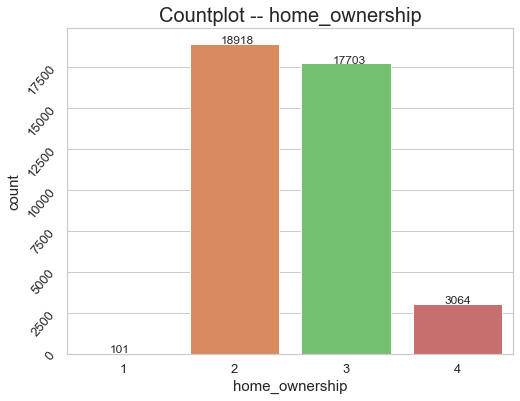

In [13]:
plot_count_distribution(df_new, "home_ownership",fontsize = 12,position=3.5)

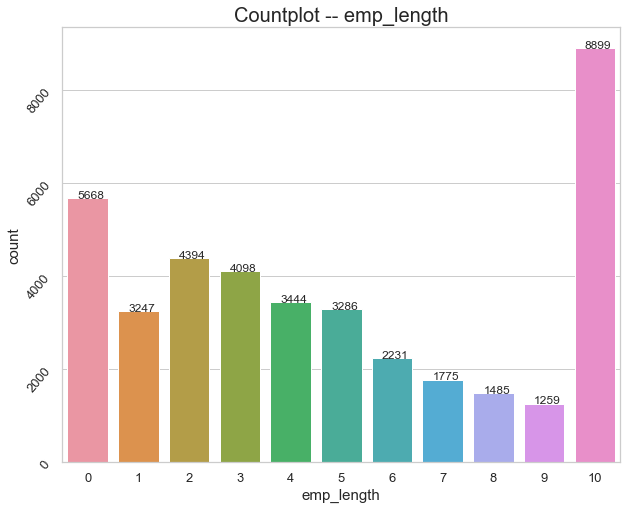

In [14]:
plot_count_distribution(df_new, "emp_length",figsize = (10,8), fontsize = 12,position=2.5)

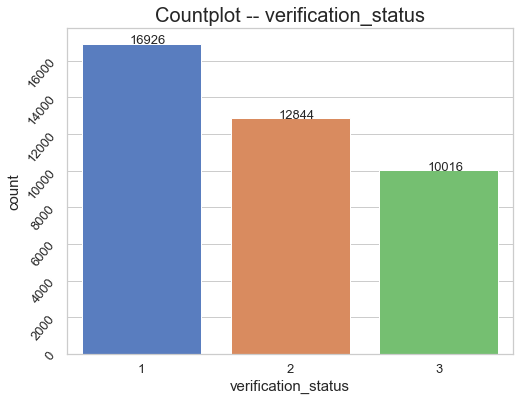

In [15]:
plot_count_distribution(df_new, "verification_status",fontsize = 13,position = 4)

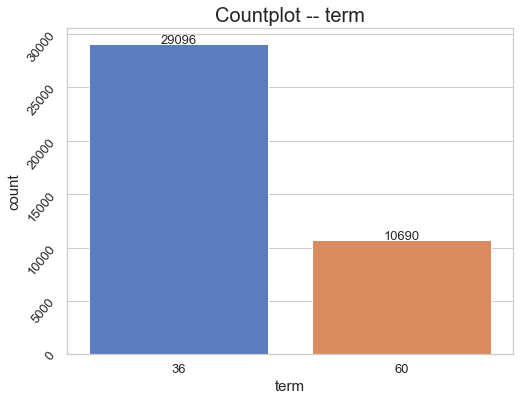

In [16]:
plot_count_distribution(df_new, "term",fontsize = 13,position = 4)

In [17]:
#### numerical features

# installment: The monthly payment owed by the borrower if the loan originates.
df_new["installment"] = df["installment"]

# annual_inc: The self-reported annual income provided by the borrower during registration.
df_new["monthly_inc"] = df["annual_inc"]/12
df_new["PaymentToIncome"] = df["installment"]/df_new["monthly_inc"]

# dti : A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
df_new["dti"] = df["dti"]

# delinq_2yrs : The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years
df_new["delinq_2yrs"] = df["delinq_2yrs"]

# inq_last_6mths : The number of inquiries in past 6 months (excluding auto and mortgage inquiries)
df_new["inq_last_6mths"] = df["inq_last_6mths"]

# open_acc : The number of open credit lines in the borrower's credit file.
df_new["open_acc"] = df["open_acc"]

# pub_rec : Number of derogatory public records
df_new["pub_rec"] = df["pub_rec"]

# revol_bal : Total credit revolving balance
df_new["revol_bal"] = df["revol_bal"]

# revol_util : Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
df_new["revol_util"] = df["revol_util"].fillna(method = "ffill")

# total_acc : The total number of credit lines currently in the borrower's credit file
df_new['total_acc'] = df["total_acc"]


In [18]:
df_new.head(10)

,loan_status,term,home_ownership,emp_length,verification_status,installment,monthly_inc,PaymentToIncome,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,charged Off,60,3,10,2,773.440,9166.667,0.084,1.060,0,0,10,0,4142,0.064,27
1,Fully Paid,36,2,10,2,327.700,4500.000,0.073,17.690,0,1,6,0,5460,0.853,11
2,charged Off,36,3,0,3,118.230,3916.667,0.030,22.520,0,3,10,0,8100,0.393,41
3,charged Off,60,4,9,3,342.900,5417.000,0.063,6.260,0,3,11,0,8990,0.775,21
4,charged Off,60,2,4,3,100.000,3750.000,0.027,7.370,0,0,10,0,4786,0.825,13
5,Fully Paid,36,2,1,3,228.270,17500.000,0.013,3.700,0,0,10,0,15610,0.358,19
6,Fully Paid,36,2,10,1,373.330,10000.000,0.037,6.440,0,2,7,0,21702,0.582,27
7,Fully Paid,60,2,10,2,397.770,4916.667,0.081,18.650,0,0,11,0,30583,0.487,31
8,charged Off,36,3,6,2,289.090,3333.333,0.087,11.310,0,0,6,0,7583,0.689,16
9,Fully Paid,60,2,10,2,728.910,11250.000,0.065,2.610,0,1,11,0,9343,0.274,31


# 3. Train and Test split

In [19]:
# from sklearn.model_selection import train_test_split
# X = df_new["loan_status"]
# Y = df_new.iloc[:,1:]
# X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=9397)


train = df_new.sample(frac=0.8,random_state=9397)
test = df_new.iloc[df_new.index.drop(train.index), :]
train = train.reset_index().drop("index",axis=1)
test = test.reset_index().drop("index",axis=1)

In [20]:
train.to_csv(os.path.join(data_path, "train.csv"),index = False)
test.to_csv(os.path.join(data_path, "test.csv"), index = False)

# 4.Resample to solve unbalanced data problem

In [78]:
# Synthetic Minority Over-sampling Technique
from collections import Counter
from imblearn.over_sampling import SMOTENC
from imblearn.under_sampling import TomekLinks
print('Original dataset shape %s' % Counter(train["loan_status"]))

# Under sampling TomekLinks
undersample = TomekLinks()
x, y = undersample.fit_resample(train.iloc[:,1:].values,train["loan_status"].values)
print('Tomek Links : Resampled dataset shape %s' % Counter(y))

# Using smoteNC to deal with categorical features(KNN)
smt = SMOTENC(categorical_features=[i for i in range(4)],random_state=42)
x, y = smt.fit_resample(x,y)
print('SMOTE : Resampled dataset shape %s' % Counter(y))
x = pd.DataFrame(x,columns=train.columns[1:])
y = pd.DataFrame(y,columns=train.columns[:1])
train_smt = pd.merge(y,x,left_index = True,right_index=True)


Original dataset shape Counter({'Fully Paid': 27260, 'charged Off': 4569})
Tomek Links : Resampled dataset shape Counter({'Fully Paid': 25127, 'charged Off': 4569})
SMOTE : Resampled dataset shape Counter({'Fully Paid': 25127, 'charged Off': 25127})


In [22]:
train_smt.to_csv(os.path.join(data_path, "train_resample.csv"),index = False)

In [23]:
train_smt

,loan_status,term,home_ownership,emp_length,verification_status,installment,monthly_inc,PaymentToIncome,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc
0,Fully Paid,60.000,2.000,4.000,3.000,388.670,4333.000,0.090,16.430,0.000,0.000,7.000,0.000,2644.000,0.482,15.000
1,Fully Paid,36.000,2.000,0.000,1.000,38.510,1600.000,0.024,10.190,0.000,0.000,9.000,0.000,6283.000,0.472,10.000
2,Fully Paid,36.000,2.000,7.000,1.000,221.280,4666.667,0.047,9.110,0.000,1.000,13.000,0.000,977.000,0.027,32.000
3,Fully Paid,36.000,3.000,0.000,3.000,167.090,4166.667,0.040,15.840,0.000,1.000,7.000,0.000,14576.000,0.684,18.000
4,Fully Paid,36.000,3.000,9.000,1.000,372.120,5000.000,0.074,16.320,1.000,0.000,9.000,0.000,13703.000,0.322,37.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50249,charged Off,60.000,2.000,5.000,1.000,137.352,4446.252,0.031,7.268,0.000,1.967,10.257,0.000,2475.432,0.303,20.967
50250,charged Off,60.000,3.000,3.000,2.000,256.988,8368.699,0.031,11.523,0.433,0.866,9.433,0.000,14700.970,0.689,27.496
50251,charged Off,60.000,2.000,10.000,2.000,161.380,5000.000,0.032,20.832,0.000,2.911,9.179,0.000,7973.249,0.429,30.927
50252,charged Off,36.000,2.000,0.000,3.000,157.957,2082.847,0.076,3.814,0.000,0.004,2.004,0.002,4800.985,0.565,7.018


# 5. Original dataset ( 2260701 * 151)

In [60]:
acp = pd.read_csv(os.path.join(data_path, "accepted_2007_to_2018Q4.csv"))
df_description = pd.read_excel(os.path.join(data_path, 'LendingClubDataDictionary.xlsx'),sheet_name = "LoanStats").dropna()
df_description.style.set_properties(subset=['Description'], **{'width': '1000px'})

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower is now delinquent.
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan application
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by the borrower during registration.
5,annual_inc_joint,The combined self-reported annual income provided by the co-borrowers during registration
6,application_type,Indicates whether the loan is an individual application or a joint application with two co-borrowers
7,avg_cur_bal,Average current balance of all accounts
8,bc_open_to_buy,Total open to buy on revolving bankcards.
9,bc_util,Ratio of total current balance to high credit/credit limit for all bankcard accounts.


In [61]:
acp.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,nan,3600.000,3600.000,3600.000,36 months,13.990,123.030,C,C4,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
1,68355089,nan,24700.000,24700.000,24700.000,36 months,11.990,820.280,C,C1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
2,68341763,nan,20000.000,20000.000,20000.000,60 months,10.780,432.660,B,B4,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
3,66310712,nan,35000.000,35000.000,35000.000,60 months,14.850,829.900,C,C5,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan
4,68476807,nan,10400.000,10400.000,10400.000,60 months,22.450,289.910,F,F1,...,nan,nan,Cash,N,NaN,NaN,NaN,nan,nan,nan


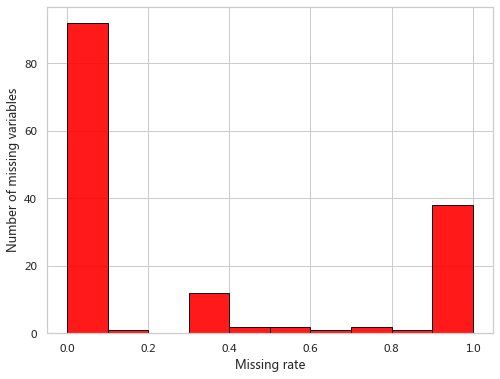

Original number of features: 151
Number of features after delete variables have missing more than 0.1: 92
Number of features after delete constant variables where one value takes more than 0.95 : 79


In [91]:
plot_missing_distribution(acp)
print("Original number of features: \033[1m{}\033[0m".format(acp.shape[1]))
missing_threshold = 0.1
df = delete_missing_variable(acp,threshold = missing_threshold)
print("Number of features after delete variables have missing more than \033[1m{}\033[0m: \033[1m{}\033[0m".format(missing_threshold, df.shape[1]))
constant_threshold = 0.95
df = delete_const_variable(df,threshold = constant_threshold)
print("Number of features after delete constant variables where one value takes more than \033[1m{}\033[0m : \033[1m{}\033[0m".format(constant_threshold, df.shape[1]))

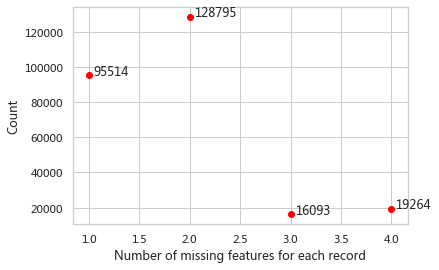

Shape of DataFrame: (2260701, 79)


In [92]:
### plot records which have missing observations
record_missing_status = df.isnull().sum(axis=1)
missing_feature_amount = np.arange(1,5)
count_of_missing_record = [sum(record_missing_status == k) for k in missing_feature_amount ]

# plot 
plt.figure()
plt.scatter(missing_feature_amount,count_of_missing_record,color = "red")
plt.ylabel('Count')
plt.xlabel('Number of missing features for each record')
for i in range(len(missing_feature_amount)):
    plt.text(missing_feature_amount[i]+0.05,
             count_of_missing_record[i],
             count_of_missing_record[i],
             #bbox=dict(facecolor='red', alpha=0.5)
            )
    
plt.show()
###
print(f"Shape of DataFrame: {df.shape}")

In [93]:
numerical = []
categorical = []
for i in df.columns:
    if df.dtypes[i] == 'int64' or df.dtypes[i] == 'float64':
        numerical.append(i)
    else:
        categorical.append(i)
print("Numerical: {}\n".format(numerical))
print("Categorical: {}".format(categorical))

Numerical: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate', 'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'out_prncp', 'out_prncp_inv', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int', 'recoveries', 'collection_recovery_fee', 'last_pymnt_amnt', 'last_fico_range_high', 'last_fico_range_low', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 'acc_open_past_24mths', 'avg_cur_bal', 'bc_open_to_buy', 'bc_util', 'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tot_hi_cred_lim', 'total_bal_e

In [94]:
# preprocess response 
print(df["loan_status"].value_counts())
df = df[(df["loan_status"]=="Fully Paid")|(df["loan_status"]=="Charged Off")]

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64


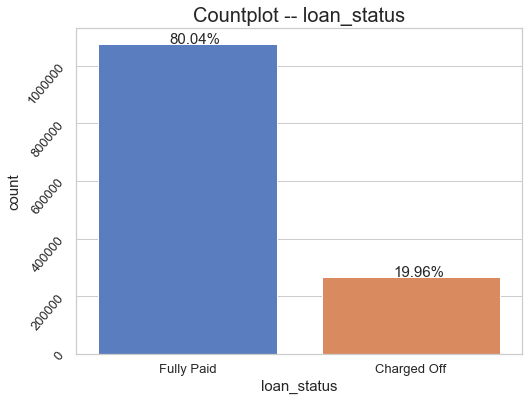

In [105]:
# unbalanced data
plot_count_distribution(df,"loan_status",position = 4, percentage=True)

In [97]:
df_new = pd.DataFrame()
# response
# df_new["loan_status"] = df["loan_status"] #.map({"Fully Paid":0, "Charged Off":1})
df_new["loan_status"] = df["loan_status"].map({"Fully Paid":"Fully Paid", "Charged Off":"charged Off"})

# term : The number of payments on the loan. Values are in months and can be either 36 or 60.
df_new["term"] = df["term"].map({" 36 months":36, " 60 months":60})

# # home_ownership: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
# df_new["home_ownership"] = df["home_ownership"].map({"NONE":1,"OTHER":1,"RENT":2,"MORTGAGE":3,"OWN":4})

# # emp_length : Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
# df["emp_length"].fillna(0,inplace=True)
# df_new["emp_length"]= np.where(df["emp_length"]== "10+ years", 10,
#                            np.where(df["emp_length"] == "1 year", 1,
#                                    np.where(df["emp_length"] == "2 years", 2,
#                                            np.where(df["emp_length"] == "3 years", 3,
#                                                    np.where(df["emp_length"] == "4 years", 4,
#                                                            np.where(df["emp_length"] == "5 years", 5,
#                                                                    np.where(df["emp_length"] == "6 years", 6,
#                                                                             np.where(df["emp_length"] == "7 years", 7,
#                                                                                      np.where(df["emp_length"] == "8 years", 8,
#                                                                                               np.where(df["emp_length"] == "9 years", 9, 0))))))))))
# # verification_status: Indicates if income was verified by LC, not verified, or if the income source was verified
# df_new["verification_status"] = df["verification_status"].map({"Not Verified":1,"Verified":2,"Source Verified":3})



In [109]:
# plot_count_distribution(df,"home_ownership")
df["url"].value_counts()

https://lendingclub.com/browse/loanDetail.action?loan_id=144274058    1
https://lendingclub.com/browse/loanDetail.action?loan_id=76449470     1
https://lendingclub.com/browse/loanDetail.action?loan_id=68408021     1
https://lendingclub.com/browse/loanDetail.action?loan_id=99984733     1
https://lendingclub.com/browse/loanDetail.action?loan_id=76498923     1
                                                                     ..
https://lendingclub.com/browse/loanDetail.action?loan_id=12405411     1
https://lendingclub.com/browse/loanDetail.action?loan_id=103278663    1
https://lendingclub.com/browse/loanDetail.action?loan_id=67408154     1
https://lendingclub.com/browse/loanDetail.action?loan_id=59270222     1
https://lendingclub.com/browse/loanDetail.action?loan_id=64581132     1
Name: url, Length: 1345310, dtype: int64

In [12]:
new2.loc[:,new2.columns[new2.dtypes==object]].head()

,term,grade,sub_grade,emp_length,home_ownership,verification_status,issue_d,loan_status,purpose,title,zip_code,addr_state,earliest_cr_line,last_pymnt_d,last_credit_pull_d
0,60 months,B,B3,10+ years,MORTGAGE,Verified,2011-11-01,Charged Off,small_business,Restaurant Inventory,945xx,CA,1971-01-01,2013-02-01,2017-07-01
1,36 months,C,C3,10+ years,RENT,Verified,2011-11-01,Fully Paid,other,familyneeds my help,334xx,FL,2001-05-01,2011-12-01,2018-10-01
2,36 months,A,A3,< 1 year,MORTGAGE,Source Verified,2011-11-01,Charged Off,car,Motorcycle Loan,132xx,NY,2002-06-01,2012-08-01,2012-08-01
3,60 months,F,F4,9 years,OWN,Source Verified,2011-11-01,Charged Off,debt_consolidation,Debt Consolidation Loan,077xx,NJ,2004-04-01,2012-04-01,2016-10-01
4,60 months,D,D3,4 years,RENT,Source Verified,2011-11-01,Charged Off,other,Medical,331xx,FL,2003-02-01,2012-06-01,2016-10-01


## check each attribute to determine whether keep it
### ["loan_amnt", "funded_amnt", "funded_amnt_inv"] these 3 attributes are similar, just choose 1.


In [12]:
# check each indivivual attribute
new2 = pd.read_csv(path+"cleaned.csv")
new3 = new2

label = new3.loc[:,["loan_status"]]
print(f"The number of instance with no label: {label.isnull().sum()}")
new3.columns[new3.isnull().sum()!=0]

The number of instance with no label: loan_status    0
dtype: int64


Index(['emp_length', 'title', 'revol_util', 'last_pymnt_d',
       'last_credit_pull_d', 'pub_rec_bankruptcies'],
      dtype='object')

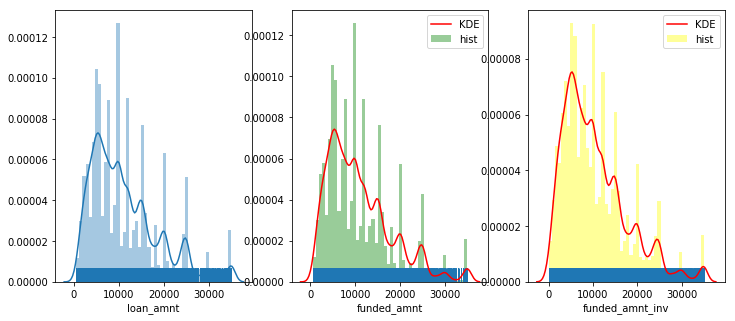

In [13]:
# visualization
fig,axes=plt.subplots(1,3,figsize=(12,5)) 
sns.distplot(new3["loan_amnt"],rug=True,ax=axes[0])
sns.distplot(new3["funded_amnt"],rug=True,
                     hist_kws={'color':'green','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'},
                     ax=axes[1])
sns.distplot(new3["funded_amnt_inv"],rug=True,
                     hist_kws={'color':'yellow','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'},
                     ax=axes[2])

In [15]:
"""
patsy 用法:
https://www.jianshu.com/p/e46a1ac36aa5
"""

#Imports
import pandas as pd
import numpy as np
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# self-defined VIF test
def VIFtest(df):
    """
    This function will use the package of statsmodels to perform the variance_inflation_factor, then return the
    result of VIF_value in the form of DataFrame
    Parameters
    ----------
    df: pandas.Dataframe
        data of features

    Returns
    ----------
    res: pandas.DataFrame
        data of the result of VIF test
    """
    # add the constant term
    # ---------------------
    # way 1
    X = add_constant(df)
    
    # way 2
    '''
    X = df[::]
    X["const"] = 1.0
    '''
    
    # way 3 patsy
    """
    features = "+".join(df.columns)
    y, X = dmatrices('df.columns[0] ~' + features, df, return_type='dataframe')
    """
    
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    return vif.round(0)

VIFtest(new2.loc[:,["loan_amnt","funded_amnt","funded_amnt_inv"]])



,VIF Factor,features
0,3.0,const
1,27.0,loan_amnt
2,39.0,funded_amnt
3,12.0,funded_amnt_inv


In [19]:
# VIF
# https://zhuanlan.zhihu.com/p/56793236
'''
#vif test

import pandas as pd
import numpy as np
from statsmodels.stats.outliers_influence import variance_inflation_factor

#宽表
data = pd.DataFrame([[15.9,16.4,19,19.1,18.8,20.4,22.7,26.5,28.1,27.6,26.3]
                     ,[149.3,161.2,171.5,175.5,180.8,190.7,202.1,212.1,226.1,231.9,239]
                     ,[4.2,4.1,3.1,3.1,1.1,2.2,2.1,5.6,5,5.1,0.7]
                     ,[108.1,114.8,123.2,126.9,132.1,137.7,146,154.1,162.3,164.3,167.6]]).T
 
#自变量
X=data[[1,2,3]]
 
#✨✨✨务必注意✨✨✨，一定要加上常数项
X[4]=1
 
#计算第2个变量的(第二列)的方差膨胀因子
variance_inflation_factor(X[[1,2,3,4]].values,1)
 
#如果没有常数项列，计算结果天差地别，可能VIF等于好几千
'''
print("used for reference")


used for reference


In [22]:
# ["loan_amnt", "funded_amnt", "funded_amnt_inv"] these 3 attributes are similar, just choose 1.
new3 = new3.drop(["funded_amnt","funded_amnt_inv"],axis=1)

### term

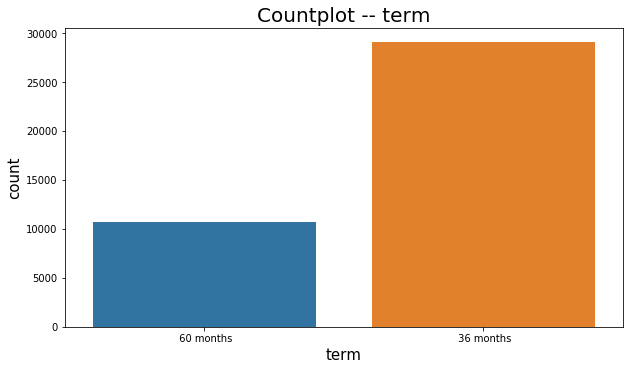

In [117]:
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(111)
sns.countplot(new3["term"])
ax.set_title("Countplot -- term",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("term",size = 15)
plt.show()
plt.close(fig)

### avoid including future information 
<br/>1.Interes rate is calculated based on the default probability and credit rank. Thus, we cannot get this information before we evaluate the credit risk. Thus, delete these two features.
<br/>2.Installment: The monthly payment owed by the borrower if the loan originates. This feature is determined by interest_rate and loan_amount. Thus ignore these attribute.
<br/>3.Grade and sub_grade are also calculated after the default probability. Those information are also future information. Delete these two features.
<br/>4.revol_bal,Total credit revolving balance!
<br/>5.revol_util, Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
<br/>6.total_pymnt,Payments received to date for total amount funded!
<br/>7.total_pymnt_inv,Payments received to date for portion of total amount funded by investors!
<br/>8.total_rec_prncp
<br/>9.total_rec_int
<br/>10.total_rec_late_fee
<br/>11.recoveries
<br/>12.collection_recovery_fee
<br/>13.last_pymnt_amnt
<br/>14.pub_rec_bankruptcies
<br/>15.'inq_last_6mths'


In [23]:
#new3["int_rate"] = (new3["int_rate"]-new3["int_rate"].min())/(new3["int_rate"].max()-new3["int_rate"].min())
#print(new3["int_rate"].describe())
#print(new3["installment"].describe())
#print(new3["grade"].describe())
#print(new3["sub_grade"].describe())
new3 = new3.drop(["int_rate", "installment","grade","sub_grade","revol_util","revol_bal",
                 "total_pymnt","total_pymnt_inv","total_rec_prncp","total_rec_int","total_rec_late_fee",
                 "collection_recovery_fee","recoveries","last_pymnt_amnt","pub_rec_bankruptcies"],axis=1)

In [24]:
new3 = new3.drop(["inq_last_6mths","pub_rec"],axis=1)

### emp_length ( fill the NA value with the method of "forward fill")
Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years. 
<br/> The missing value is less than 5% of the sample, so we propagate last valid observation forward to next 

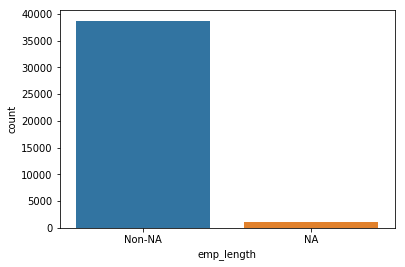

In [120]:
temp = new3["emp_length"].copy()
temp[temp.isnull()] ="NA"
temp[temp!="NA"] ="Non-NA"
sns.countplot(temp)


In [25]:
new3["emp_length"]=new3["emp_length"].fillna(method ='ffill')

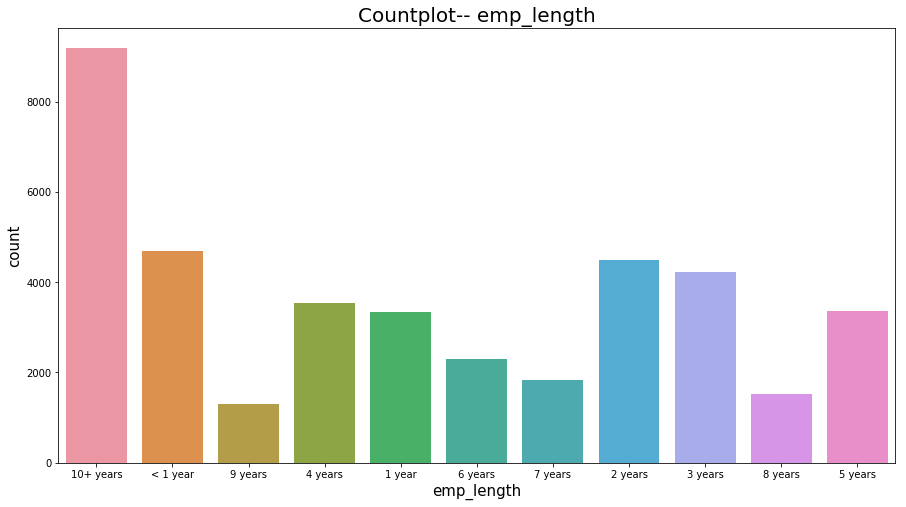

In [122]:
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)

sns.countplot(new3["emp_length"])

ax.set_title("Countplot-- emp_length",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("emp_length",size = 15)

plt.show()
plt.close(fig)


### home_ownership
The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER

count     39786
unique        5
top        RENT
freq      18918
Name: home_ownership, dtype: object


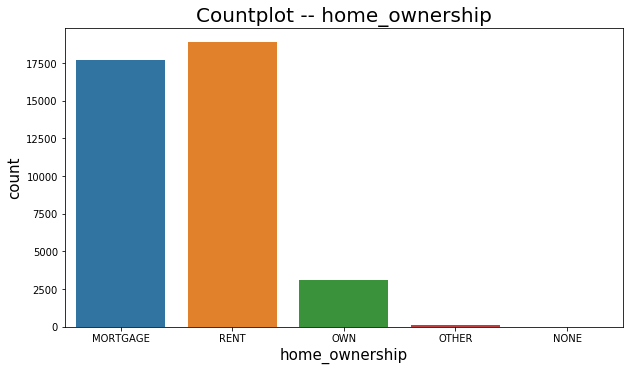

In [123]:
print(new3["home_ownership"].describe())
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(111)
sns.countplot(new3["home_ownership"])
ax.set_title("Countplot -- home_ownership",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("home_ownership",size = 15)
plt.show()
plt.close(fig)


### annual_inc
The self-reported annual income provided by the borrower during registration.

count    3.978600e+04
mean     6.897907e+04
std      6.376263e+04
min      4.000000e+03
25%      4.050000e+04
50%      5.900000e+04
75%      8.234250e+04
max      6.000000e+06
Name: annual_inc, dtype: float64


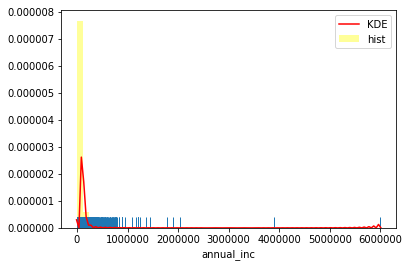

In [26]:
print(new3["annual_inc"].describe())
sns.distplot(new3["annual_inc"],rug=True,
                     hist_kws={'color':'yellow','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'})

### verification_status
Indicates if income was verified by LC, not verified, or if the income source was verified

count            39786
unique               3
top       Not Verified
freq             16926
Name: verification_status, dtype: object


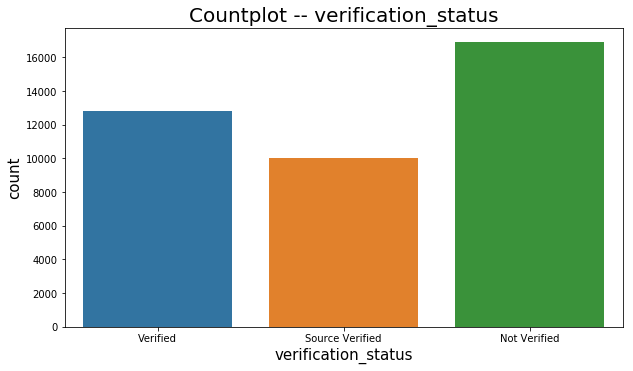

In [71]:
print(new3["verification_status"].describe())
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(111)
sns.countplot(new3["verification_status"])
ax.set_title("Countplot -- verification_status",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("verification_status",size = 15)
plt.show()
plt.close(fig)


### delete all the date attribute: ["issue_d","earliest_cr_line","last_pymnt_d","last_credit_pull_d"]
Date are not useful in the classification

In [27]:
new3 = new3.drop(["issue_d","earliest_cr_line","last_pymnt_d","last_credit_pull_d"],axis=1)

### Purpose
A category provided by the borrower for the loan request. 

count                  39786
unique                    14
top       debt_consolidation
freq                   18676
Name: purpose, dtype: object


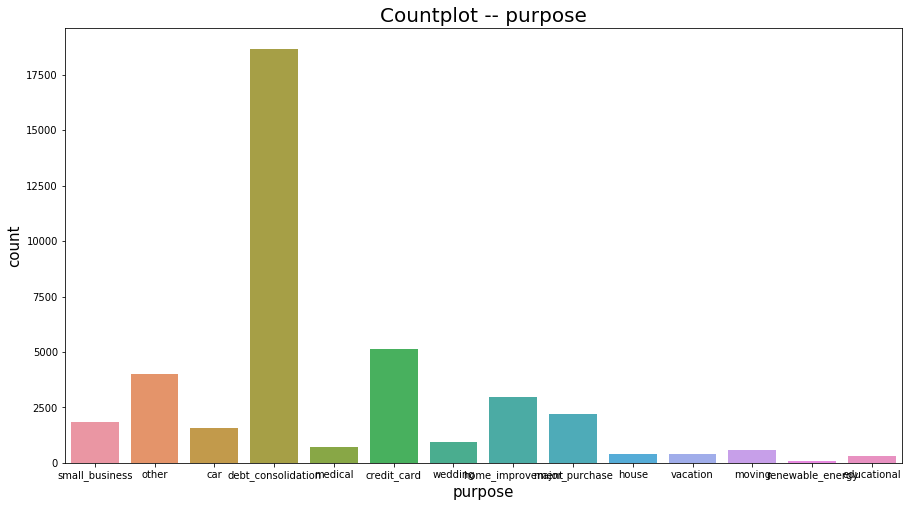

In [72]:
print(new3["purpose"].describe())
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
sns.countplot(new3["purpose"])
ax.set_title("Countplot -- purpose",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("purpose",size = 15)
plt.show()
plt.close(fig)

### title
The loan title provided by the borrower.There is no standardized label. Duplicated labels exist, like:
1. "Debt Consolidation","Debt Consolidation Loan","Debt consolidation","Consolidation", "consolidation"
2. "Personal", "personal", "personal loan","loan"

In [28]:
# count the frequency of "title"
new3.loc[:,["title"]].apply(pd.value_counts)
new3 = new3.drop(["title",],axis=1)

# > 90% similarity
#new3.loc[:,["pub_rec"]].apply(pd.value_counts)
#new3 = new3.drop(["pub_rec",],axis=1)

new3.shape

(39786, 15)

### zip_code & addr_state: those two attributes contain similar infomation, so just keep one

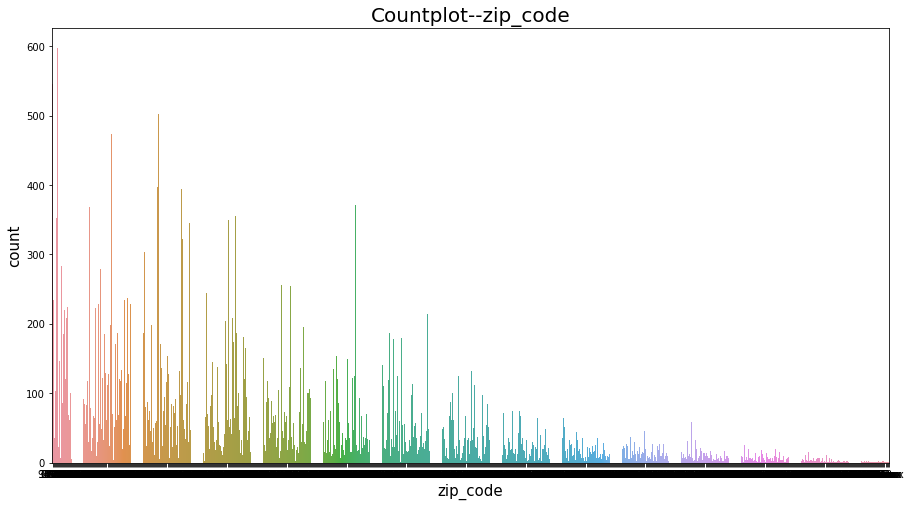

count     39786
unique      823
top       100xx
freq        597
Name: zip_code, dtype: object


In [64]:
# visualization 
temp = new3["zip_code"]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
sns.countplot(temp)

ax.set_title("Countplot--zip_code",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("zip_code",size = 15)

plt.show()
plt.close(fig)
print(new3["zip_code"].describe())

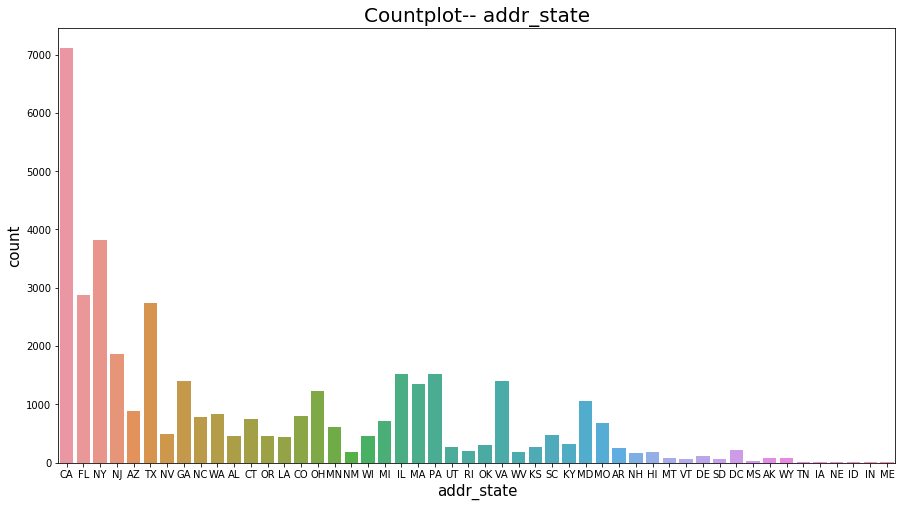

In [41]:
# visualization 
temp = new3["addr_state"]

fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111)
sns.countplot(temp)

ax.set_title("Countplot-- addr_state",size=20)
ax.set_ylabel("count",size = 15)
ax.set_xlabel("addr_state",size = 15)

plt.show()
plt.close(fig)

In [29]:
# drop zip_code 
new3 = new3.drop(["zip_code",],axis=1)

### dti
A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.

count    39786.000000
mean        13.317794
std          6.678300
min          0.000000
25%          8.180000
50%         13.410000
75%         18.600000
max         29.990000
Name: dti, dtype: float64


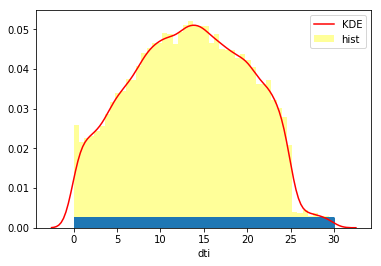

In [43]:
print(new3["dti"].describe())
sns.distplot(new3["dti"],rug=True,
                     hist_kws={'color':'yellow','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'})

### total_acc & open_acc (only keep one)
The total number of credit lines currently in the borrower's credit file

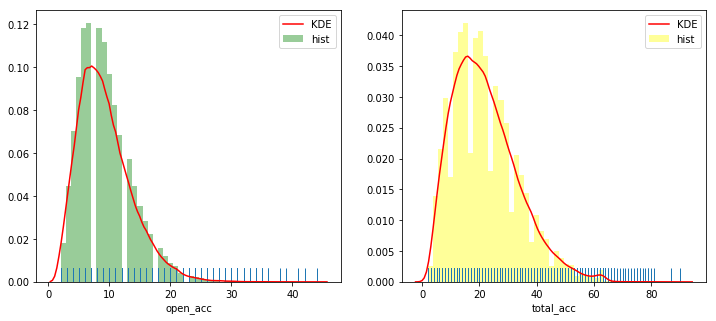

In [48]:
new3["total_acc"].describe()
new3["open_acc"].describe()

# visualization
fig,axes=plt.subplots(1,2,figsize=(12,5)) 

sns.distplot(new3["open_acc"],rug=True,
                     hist_kws={'color':'green','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'},
                     ax=axes[0])
sns.distplot(new3["total_acc"],rug=True,
                     hist_kws={'color':'yellow','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'},
                     ax=axes[1])




In [30]:
new3 = new3.drop(["total_acc"],axis=1)

## 'delinq_2yrs'

count    39786.000000
mean         0.146534
std          0.491826
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         11.000000
Name: delinq_2yrs, dtype: float64


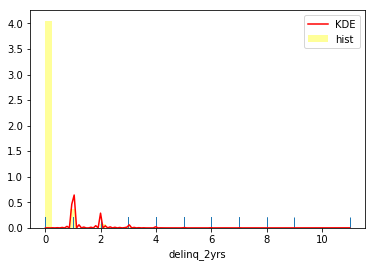

In [77]:
print(new3['delinq_2yrs'].describe())
sns.distplot(new3["delinq_2yrs"],rug=True,
                     hist_kws={'color':'yellow','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'})

## missing_amnt

count    39786.000000
mean         0.051802
std          0.252883
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: missing_amnt, dtype: float64


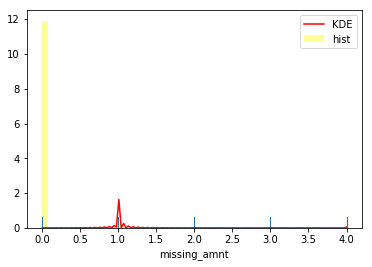

In [79]:
print(new3['missing_amnt'].describe())
sns.distplot(new3["missing_amnt"],rug=True,
                     hist_kws={'color':'yellow','label':'hist'},
                     kde_kws={'color':'red','label':'KDE'})

In [31]:
print(new3.shape)
freeze_header(new3)
new3.to_csv(path+"data.csv",index=False)

(39786, 13)


interactive(children=(IntSlider(value=1000, description='rows', max=39786, min=1000, readout=False, step=1000)…

In [32]:
new3.columns

Index(['loan_amnt', 'term', 'emp_length', 'home_ownership', 'annual_inc',
       'verification_status', 'loan_status', 'purpose', 'addr_state', 'dti',
       'delinq_2yrs', 'open_acc', 'missing_amnt'],
      dtype='object')

,loan_amnt,annual_inc,loan_status,dti
0,1.000000,0.017678,Charged Off,0.035345
1,0.260870,0.008339,Fully Paid,0.589863
2,0.095652,0.007171,Charged Off,0.750917
3,0.344928,0.010174,Charged Off,0.208736
4,0.101449,0.006838,Charged Off,0.245749


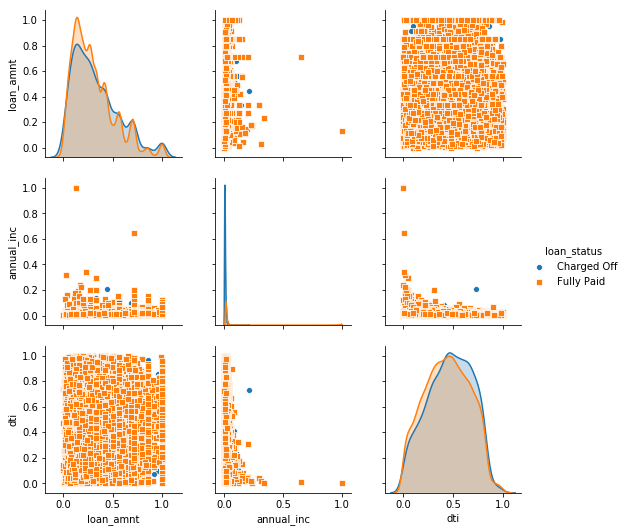

In [251]:
'''
da = pd.read_csv(path+"data.csv")
da = da.iloc[:,[1,5,7,10]]
da["loan_amnt"] = (da["loan_amnt"]-da['loan_amnt'].min())/(da['loan_amnt'].max()-da["loan_amnt"].min())
da["annual_inc"] = (da["annual_inc"]-da['annual_inc'].min())/(da['annual_inc'].max()-da["annual_inc"].min())
da["dti"] = (da["dti"]-da['dti'].min())/(da['dti'].max()-da["dti"].min())
sns.pairplot(da, hue="loan_status",markers=["o", "s"])
da.head()
'''

# Scaling
## Normalization of numerical attributes

In [33]:
new3=pd.read_csv(path+"data.csv")
# normalization
new3["loan_amnt"] = (new3["loan_amnt"] - new3["loan_amnt"].min())/(new3["loan_amnt"].max()-new3["loan_amnt"].min())
new3["annual_inc"] = (new3["annual_inc"] - new3["annual_inc"].min())/(new3["annual_inc"].max()-new3["annual_inc"].min())
new3["dti"] = (new3["dti"] - new3["dti"].min())/(new3["dti"].max()-new3["dti"].min())
new3["open_acc"] = (new3["open_acc"] - new3["open_acc"].min())/(new3["open_acc"].max()-new3["open_acc"].min())
new3["delinq_2yrs"] = (new3["delinq_2yrs"] - new3["delinq_2yrs"].min())/(new3["delinq_2yrs"].max()-new3["delinq_2yrs"].min())
new3["missing_amnt"] = (new3["missing_amnt"] - new3["missing_amnt"].min())/(new3["missing_amnt"].max()-new3["missing_amnt"].min())

In [34]:
freeze_header(new3)
new3.shape

interactive(children=(IntSlider(value=1000, description='rows', max=39786, min=1000, readout=False, step=1000)…

(39786, 13)

## convert categorical variable into dummy variable

In [35]:
# get_dummies
d1=pd.get_dummies(new3["term"])
d2=pd.get_dummies(new3["emp_length"])
d3=pd.get_dummies(new3["home_ownership"])
d4=pd.get_dummies(new3["verification_status"])
d5=pd.get_dummies(new3["purpose"])
d6=pd.get_dummies(new3["addr_state"])
new3.drop(['term', 'emp_length', 'home_ownership','verification_status','purpose', 'addr_state'],axis=1,inplace = True)
new3 = pd.concat([new3,d1,d2,d3,d4,d5,d6],axis=1)
new3.to_csv(path+"final_clean_set.csv",index = False)

# alternative algo: labelencoder

'''
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
for col in data.columns:
    data[col] = labelencoder.fit_transform(data[col])
 
data.head()
 
y = data['class']    #用列名访问更直观
X = data.drop('class', axis = 1)
'''
# alternative algo: one hot encoder （同时需要降维） 一般不用再tree model
# https://www.cnblogs.com/king-lps/p/7846414.html


"\nfrom sklearn.preprocessing import LabelEncoder\nlabelencoder=LabelEncoder()\nfor col in data.columns:\n    data[col] = labelencoder.fit_transform(data[col])\n \ndata.head()\n \ny = data['class']    #用列名访问更直观\nX = data.drop('class', axis = 1)\n"

In [44]:
new4= pd.read_csv(path+"final_clean_set.csv")
freeze_header(new4)

interactive(children=(IntSlider(value=1000, description='rows', max=39786, min=1000, readout=False, step=1000)…

# 3.Split sample set into training set and test set-- 9:1

In [45]:
from sklearn.model_selection import train_test_split
Y = new4.loc[:,"loan_status"]
X = new4.drop(["loan_status"],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.1, random_state = 190003956)


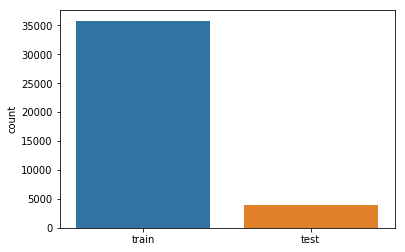

In [46]:
L=["train"]*X_train.shape[0]+["test"]*X_test.shape[0]
sns.countplot(L)

# 4. Data Mining

## Decision Tree

In [47]:
from sklearn.tree import DecisionTreeClassifier 
# Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics 
# gridesearchCV
from  sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score


In [61]:
'''
https://blog.csdn.net/evolution23/article/details/85235397
criterion: "gini" --- CART, "entropy" --- ID3, C4.5
splitter: "best" --- small dataset, "random" --- large dataset
max_depth(树的深度)
max_leaf_nodes(节点树木)
max_features(最大特征数)
min_samples_leaf(叶子结点的最小样本数)
min_sample_split(中间节点的最小样本数)
min_weight_fraction_leaf(叶子夜店的样本权重占总权重的比例)
min_impurity_split(最小不纯净度)
'''

# Create Decision Tree classifer object
Tree = DecisionTreeClassifier()

Max_depth = range(5,15,1)
Min_sample_leaf = range(1,10,2)
tuned_paramters = dict(max_depth = Max_depth, min_samples_leaf = Min_sample_leaf)

# Train Decision Tree Classifer
DD = GridSearchCV(Tree, tuned_paramters, cv = 10)
clf = DD.fit(X_train,y_train)

Best: 0.856453 using {'max_depth': 5, 'min_samples_leaf': 5}
The AUC of GridSearchCV Desicion Tree is 0.4998540572095738


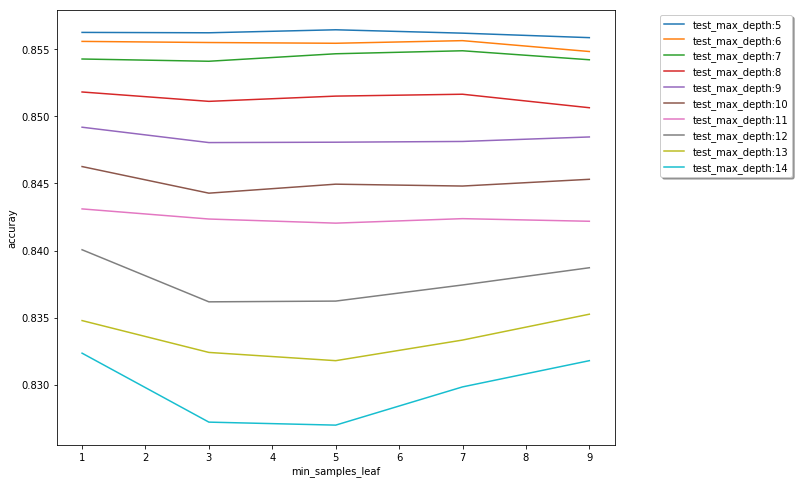

In [62]:
print("Best: %f using %s" % (DD.best_score_, DD.best_params_))
 
y_prob = DD.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
#DD.score(X_test, y_pred)
 
print('The AUC of GridSearchCV Desicion Tree is', roc_auc_score(y_test,y_pred))

#DD.grid_scores_
 
test_means = DD.cv_results_[ 'mean_test_score' ]
#test_stds = DD.cv_results_[ 'std_test_score' ]
#pd.DataFrame(DD.cv_results_).to_csv('DD_min_samples_leaf_maxdepth.csv')
 
# plot results
test_scores = np.array(test_means).reshape(len(Max_depth), len(Min_sample_leaf))
 
fig = plt.figure(figsize=(10,8))
for i, value in enumerate(Max_depth):
    plt.plot(Min_sample_leaf, test_scores[i], label= 'test_max_depth:'   + str(value))
 
plt.legend(loc='upper center', bbox_to_anchor=(1.2, 1), shadow=True, ncol=1)
plt.xlabel( 'min_samples_leaf' )                                                                                                      
plt.ylabel( 'accuray' )
plt.show()



In [63]:
# Create Decision Tree classifer object
Tree_res = DecisionTreeClassifier(criterion="entropy")

# Train Decision Tree Classifer
Tree_res = Tree_res.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = Tree_res.predict(X_test)

# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7587333500879618


Accuracy: 0.7587333500879618
[[2913  513]
 [ 447  106]]


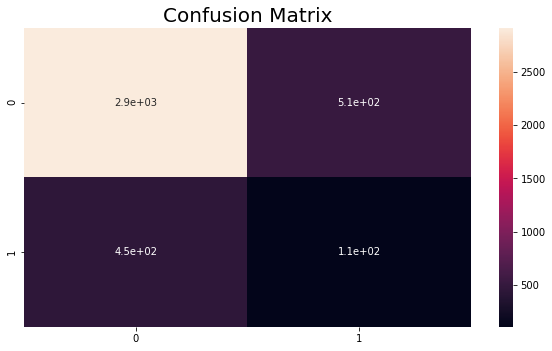

In [64]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y_test, y_pred, labels=["Fully Paid","Charged Off"])

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(conf_matrix)
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(111)

sns.heatmap(conf_matrix, annot=True)
ax.set_title("Confusion Matrix",size=20)


plt.show()
plt.close(fig)

In [74]:
from sklearn.tree import DecisionTreeClassifier
 
model_tree = DecisionTreeClassifier()
model_tree.fit(X_train, y_train)
y_prob = model_tree.predict_proba(X_test)[:,1] # This will give you positive class prediction probabilities  
y_pred = np.where(y_prob > 0.5, 1, 0) # This will threshold the probabilities to give class predictions.
model_tree.score(X_test, y_pred)
print('The AUC of default Desicion Tree is',roc_auc_score(y_test,y_pred))
 
#
df = pd.DataFrame({"columns":list(columns), "importance":list(model_tree.feature_importances_.T)})
df.sort_values(by=['importance'],ascending=False)
 
plt.bar(range(len(model_tree.feature_importances_)), model_tree.feature_importances_)

y_pred.head()

array([1, 1, 1, ..., 1, 1, 1])

### visualization of tree

In [66]:
"""
from sklearn import tree
#After training，use export_graphviz to export the Tree into Graphviz format
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

import pydotplus
dot_data=tree.export_graphviz(clf,out_file=None)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('iris_2.pdf')


Feature = new4.columns
target = ["Charged Off","Fully Paid"]
from IPython.display import Image  
dot_data = tree.export_graphviz(clf) 
                                #out_file=None, 
                         #feature_names=new4.columns,
                         #class_names=target,
                         #filled=True, rounded=True,
                         #special_characters = True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  
"""

'\nfrom sklearn import tree\n#After training，use export_graphviz to export the Tree into Graphviz format\nwith open("iris.dot", \'w\') as f:\n    f = tree.export_graphviz(clf, out_file=f)\n\nimport pydotplus\ndot_data=tree.export_graphviz(clf,out_file=None)\ngraph=pydotplus.graph_from_dot_data(dot_data)\ngraph.write_pdf(\'iris_2.pdf\')\n\n\nFeature = new4.columns\ntarget = ["Charged Off","Fully Paid"]\nfrom IPython.display import Image  \ndot_data = tree.export_graphviz(clf) \n                                #out_file=None, \n                         #feature_names=new4.columns,\n                         #class_names=target,\n                         #filled=True, rounded=True,\n                         #special_characters = True)  \ngraph = pydotplus.graph_from_dot_data(dot_data)  \nImage(graph.create_png())  \n'

In [ ]:

# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)

In [8]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7584820306609701


In [ ]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

#dot_data = StringIO()
#export_graphviz(Tree, out_file=dot_data,  filled=True, rounded=True, special_characters=True,feature_names = list(X_train.columns),class_names=['Charged Off','Fully Paid'])
#graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
#graph.write_png(path+'diabetes.png')
#Image(graph.create_png())

dot_data = StringIO()
export_graphviz(Tree1, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### use iris dataset to plot the decision tree

In [68]:
from sklearn import tree
from sklearn.datasets import load_iris 

#载入sklearn中自带的数据Iris，构造决策树

iris=load_iris()
clf=tree.DecisionTreeClassifier()
clf=clf.fit(iris.data,iris.target)
from sklearn import tree
#After training，use export_graphviz to export the Tree into Graphviz format
with open("iris.dot", 'w') as f:
    f = tree.export_graphviz(clf, out_file=f)

import pydotplus
dot_data=tree.export_graphviz(clf,out_file=None)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('iris_2.pdf')

True

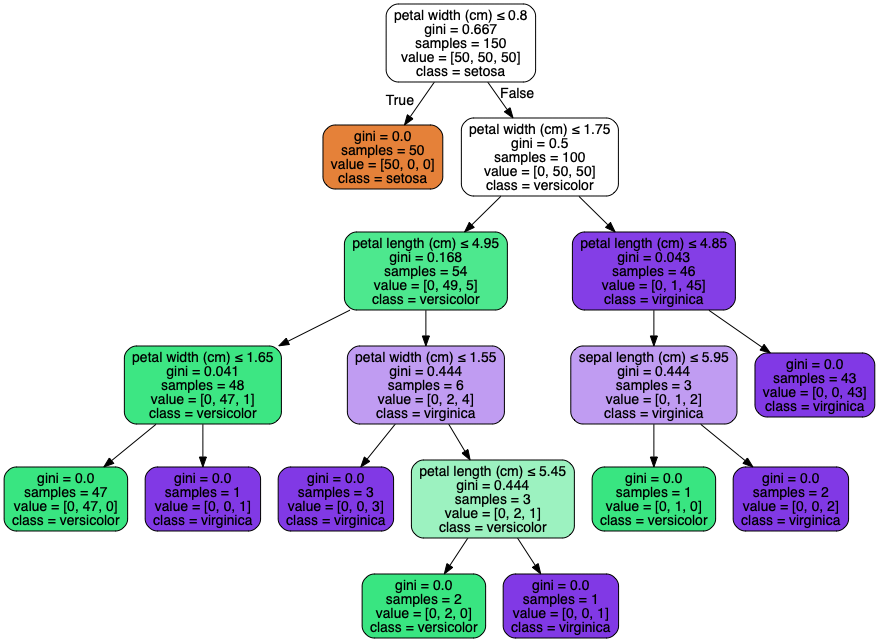

In [69]:
import pydotplus
dot_data=tree.export_graphviz(clf,out_file=None)
graph=pydotplus.graph_from_dot_data(dot_data)
graph.write_pdf('iris_2.pdf')
from IPython.display import Image  
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=iris.feature_names,  
                         class_names=iris.target_names,  
                         filled=True, rounded=True,  
                         special_characters=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

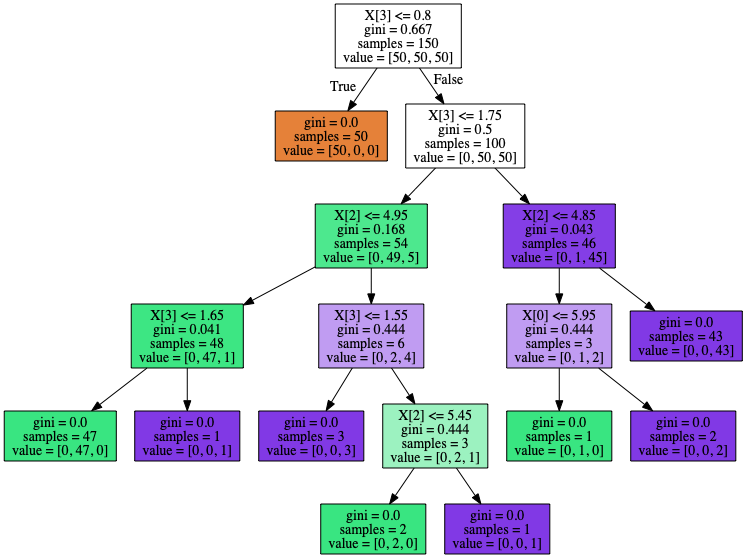

In [70]:
dot_data = tree.export_graphviz(clf, out_file = None,filled=True)  
graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())  

## Support Vector Machine

In [8]:
#Import svm model
from sklearn import svm

#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)


In [11]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

svm_linear = SVC(C=1.0, kernel="linear", gamma="auto" )
svm_poly = SVC(C=1.0, kernel="poly", degree=3, gamma="auto")
svm_rbf = SVC(C=1.0, kernel="rbf", gamma=0.5)

svms = [svm_linear, svm_poly, svm_rbf]

for svm, i in zip(svms, range(len(svms))):
    svm.fit(X_train, y_train)
    predicted_svm = svm.predict(X_test)
    acc_svm = (accuracy_score(X_test, predicted_svm))
    print ("Accuracy: \t", acc_svm)

Accuracy: 0.8595124403116361


## Random Forest

In [83]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=300)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [84]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
name = X.columns

Accuracy: 0.8610203568735864


In [85]:
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

No handles with labels found to put in legend.


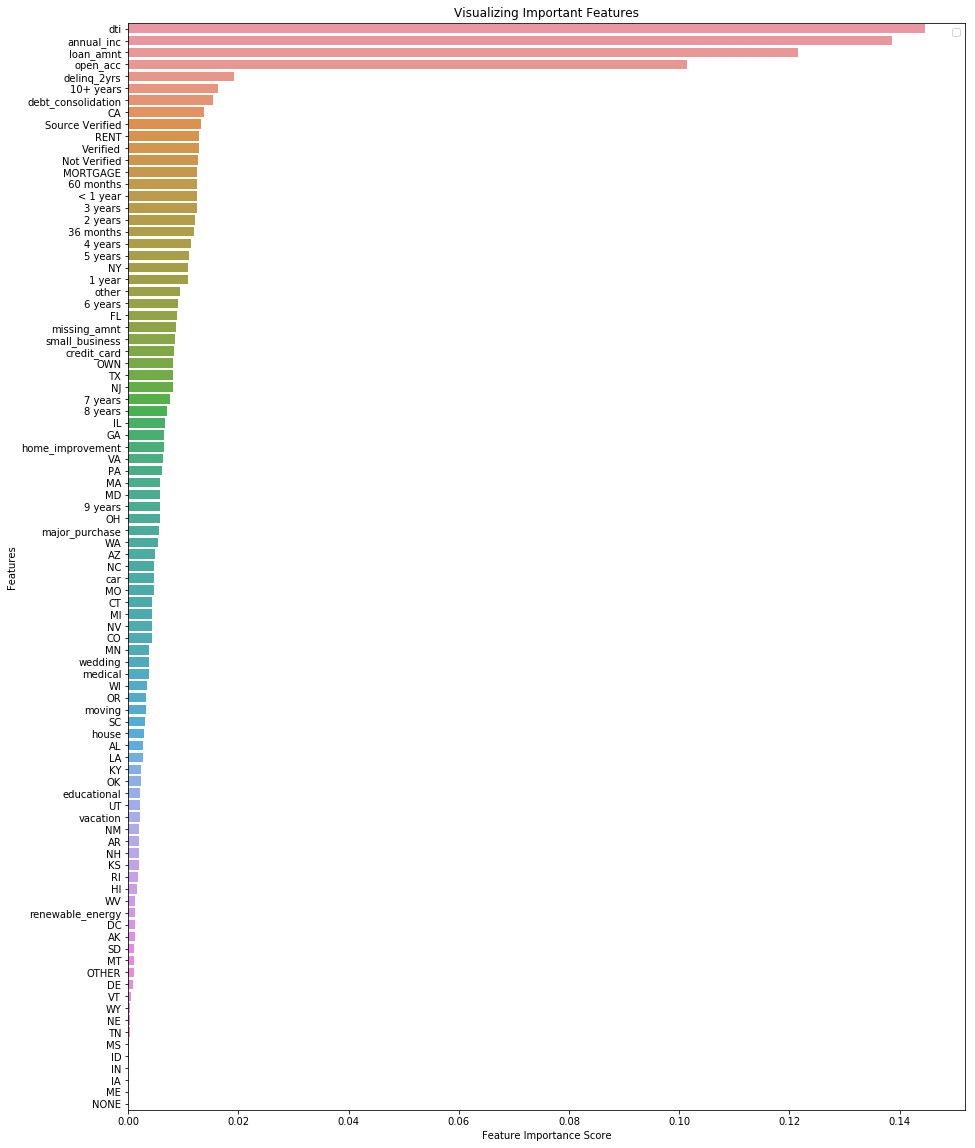

In [86]:
import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=name).sort_values(ascending=False)
feature_imp
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
fig = plt.figure(figsize=(15,20))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

Accuracy: 0.8595124403116361
[[3418    8]
 [ 551    2]]


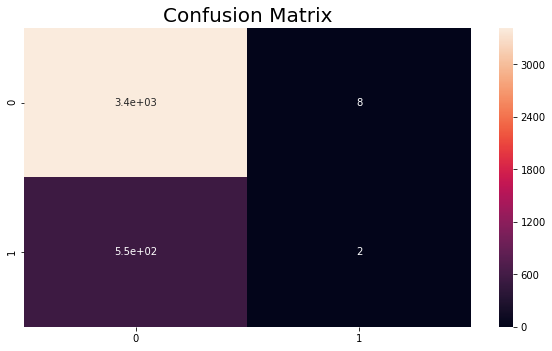

In [79]:
from sklearn.metrics import confusion_matrix
conf_matrix=confusion_matrix(y_test, y_pred, labels=["Fully Paid","Charged Off"])

print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
print(conf_matrix)
fig = plt.figure(figsize=(10,5.5))
ax = fig.add_subplot(111)

sns.heatmap(conf_matrix, annot=True)
ax.set_title("Confusion Matrix",size=20)


plt.show()
plt.close(fig)

In [91]:
from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.metrics import accuracy_score
for n_estimator in range(1, 300, 15):
    rf = rfc(n_estimators=n_estimator)
    rf.fit(X_train, y_train)
    predicted_rf = rf.predict(X_test)
    acc_rf = (accuracy_score(y_test, predicted_rf))
    print ("Accuracy: with estimator =\t ", n_estimator, "\t", acc_rf)

Accuracy: with estimator =	  1 	 0.770545363156572
Accuracy: with estimator =	  16 	 0.8514702186479015
Accuracy: with estimator =	  31 	 0.8585071626036692
Accuracy: with estimator =	  46 	 0.8580045237496858
Accuracy: with estimator =	  61 	 0.8597637597386278
Accuracy: with estimator =	  76 	 0.8590098014576527
Accuracy: with estimator =	  91 	 0.8592611208846443
Accuracy: with estimator =	  106 	 0.8600150791656195
Accuracy: with estimator =	  121 	 0.8607690374465946
Accuracy: with estimator =	  136 	 0.8610203568735864
Accuracy: with estimator =	  151 	 0.8600150791656195
Accuracy: with estimator =	  166 	 0.8602663985926112
Accuracy: with estimator =	  181 	 0.8602663985926112
Accuracy: with estimator =	  196 	 0.8600150791656195
Accuracy: with estimator =	  211 	 0.8600150791656195
Accuracy: with estimator =	  226 	 0.8610203568735864
Accuracy: with estimator =	  241 	 0.8610203568735864
Accuracy: with estimator =	  256 	 0.8607690374465946
Accuracy: with estimator =	  271 	 0.

In [81]:
2913/(2913+447)

0.8669642857142857

## KNN

In [87]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

# Train the model using the training sets
knn.fit(X_train,y_train)

#Predict Output
y_pred = knn.predict(X_test)

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))



Accuracy: 0.8180447348580046


In [89]:
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.metrics import accuracy_score
for k in range(1,10):
    for p in range(1,5):
        knn=knc(n_neighbors=k, weights="distance", p=p)
        knn.fit(X_train, y_train)
        predicted_knn = knn.predict(X_test)
        acc_knn = (accuracy_score(y_test, predicted_knn))
        print ("Accuracy: with k = ", k, "  and p value in Minkowski distance = ", p, "\t", acc_knn)

Accuracy: with k =  1   and p value in Minkowski distance =  1 	 0.7657702940437295
Accuracy: with k =  1   and p value in Minkowski distance =  2 	 0.7670268911786882
Accuracy: with k =  1   and p value in Minkowski distance =  3 	 0.7675295300326715
Accuracy: with k =  1   and p value in Minkowski distance =  4 	 0.7690374465946218
Accuracy: with k =  2   and p value in Minkowski distance =  1 	 0.7657702940437295
Accuracy: with k =  2   and p value in Minkowski distance =  2 	 0.7670268911786882
Accuracy: with k =  2   and p value in Minkowski distance =  3 	 0.7675295300326715
Accuracy: with k =  2   and p value in Minkowski distance =  4 	 0.7690374465946218
Accuracy: with k =  3   and p value in Minkowski distance =  1 	 0.7956773058557427
Accuracy: with k =  3   and p value in Minkowski distance =  2 	 0.7974365418446846
Accuracy: with k =  3   and p value in Minkowski distance =  3 	 0.7991957778336265
Accuracy: with k =  3   and p value in Minkowski distance =  4 	 0.800201055

In [90]:
from sklearn.neighbors import KNeighborsClassifier as knc
from sklearn.metrics import accuracy_score
for k in range(1,10):
    for p in range(1,5):
        knn=knc(n_neighbors=k, weights="distance", p=p)
        knn.fit(X_train, y_train)
        predicted_knn = knn.predict(X_test)
        acc_knn = (accuracy_score(y_test, predicted_knn))
        print ("Accuracy: with k = ", k, "  and p value in Minkowski distance = ", p, "\t", acc_knn)

Accuracy: with k =  1   and p value in Minkowski distance =  1 	 0.7657702940437295
Accuracy: with k =  1   and p value in Minkowski distance =  2 	 0.7670268911786882
Accuracy: with k =  1   and p value in Minkowski distance =  3 	 0.7675295300326715
Accuracy: with k =  1   and p value in Minkowski distance =  4 	 0.7690374465946218
Accuracy: with k =  2   and p value in Minkowski distance =  1 	 0.7657702940437295
Accuracy: with k =  2   and p value in Minkowski distance =  2 	 0.7670268911786882
Accuracy: with k =  2   and p value in Minkowski distance =  3 	 0.7675295300326715
Accuracy: with k =  2   and p value in Minkowski distance =  4 	 0.7690374465946218
Accuracy: with k =  3   and p value in Minkowski distance =  1 	 0.7956773058557427
Accuracy: with k =  3   and p value in Minkowski distance =  2 	 0.7974365418446846
Accuracy: with k =  3   and p value in Minkowski distance =  3 	 0.7991957778336265
Accuracy: with k =  3   and p value in Minkowski distance =  4 	 0.800201055

## Linear discriminant analysis
### LDA

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as lda
from sklearn.metrics import accuracy_score
ld = lda()
ld.fit(train_x, train_y)
predicted_ld = ld.predict(test_x)
acc_ld = (accuracy_score(test_y, predicted_ld))
acc_ld

/Users/yifuhe/anaconda3/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


# evaluation part by kelvin

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Dec  9 20:39:33 2019

@author: peng_kaiwen
"""

#importing libraries
import numpy as np
import pandas as pd
from matplotlib import cm

#loading the dataset
dataset = pd.read_csv('dataset-4.csv')
#X = dataset.iloc[:,0:6].values
X = dataset.iloc[:,0:3].values
y = dataset.iloc[:,len(dataset.iloc[0])-1].values

#train/test
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

#fitting the classifier to the training set
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion='entropy', random_state=0)
classifier.fit(X_train, y_train)


import matplotlib.pyplot as plt
from scipy import integrate
def capcurve(y_values, y_preds_proba):
    num_pos_obs = np.sum(y_values)
    num_count = len(y_values)
    rate_pos_obs = float(num_pos_obs) / float(num_count)
    ideal = pd.DataFrame({'x':[0,rate_pos_obs,1],'y':[0,1,1]})
    xx = np.arange(num_count) / float(num_count - 1)

    y_cap = np.c_[y_values,y_preds_proba]
    y_cap_df_s = pd.DataFrame(data=y_cap)
    y_cap_df_s = y_cap_df_s.sort_values([1], ascending=False).reset_index('index', drop=True)

    print(y_cap_df_s.head(20))

    yy = np.cumsum(y_cap_df_s[0]) / float(num_pos_obs)
    yy = np.append([0], yy[0:num_count-1]) #add the first curve point (0,0) : for xx=0 we have yy=0

    percent = 0.5
    row_index = np.trunc(num_count * percent)

    val_y1 = yy[row_index]
    val_y2 = yy[row_index+1]
    if val_y1 == val_y2:
        val = val_y1*1.0
    else:
        val_x1 = xx[row_index]
        val_x2 = xx[row_index+1]
        val = val_y1 + ((val_x2 - percent)/(val_x2 - val_x1))*(val_y2 - val_y1)

    sigma_ideal = 1 * xx[num_pos_obs - 1 ] / 2 + (xx[num_count - 1] - xx[num_pos_obs]) * 1
    sigma_model = integrate.simps(yy,xx)
    sigma_random = integrate.simps(xx,xx)

    ar_value = (sigma_model - sigma_random) / (sigma_ideal - sigma_random)
    #ar_label = 'ar value = %s' % ar_value
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1)
    ax.plot(ideal['x'],ideal['y'], color='grey', label='Perfect Model')
    ax.plot(xx,yy, color='red', label='User Model')
    #ax.scatter(xx,yy, color='red')
    ax.plot(xx,xx, color='blue', label='Random Model')
    ax.plot([percent, percent], [0.0, val], color='green', linestyle='--', linewidth=1)
    ax.plot([0, percent], [val, val], color='green', linestyle='--', linewidth=1, label=str(val*100)+'% of positive obs at '+str(percent*100)+'%')
    
    plt.xlim(0, 1.02)
    plt.ylim(0, 1.25)
    plt.title("CAP Curve - a_r value ="+str(ar_value))
    plt.xlabel('% of the data')
    plt.ylabel('% of positive obs')
    plt.legend()
    plt.show()
    
    
y_pred_proba = classifier.predict_proba(X=X_test)
capcurve(y_values=y_test, y_preds_proba=y_pred_proba[:,1])
